In [294]:
path = "PRIMNET/FINGER"

from path_handler import get_BASERDIR
import os
BASEDIR, RUNMODE = get_BASERDIR(".")

if BASEDIR.absolute().name == "control":
    os.chdir("..")
os.getcwd()

Running on Jupyter...


'/home/taerim/sOftrobot/PRIMNET-V2/code'

In [295]:
# %%
from pathlib import Path
import sys

try: 
    get_ipython().__class__.__name__
    BASEDIR = Path().absolute()
except: BASEDIR = Path(__file__).parent

sys.path.append(str(BASEDIR))
import torch
from torch import nn
import argparse

import numpy as np
from utils import dataloader
from utils.initalize import INITALZE_EVEN_JOINTS
from utils.update import  update_primnet, update_fc_primnet, update_pcc_primnet


import os
import random
from pathlib import Path
import wandb
import time
import json

from utils.tools import set_seed, set_wandb, print_log_dict, prefix_dict, average_dict
from utils.path_handler import JUPYTER, RUN, DEBUG, get_BASERDIR
from utils.args import read_ARGS
from utils.logger import CSVLogger,ask_and_make_folder
from utils.tools import cast_numpy

from configs.template import PRIMNET_ARGS_TEMPLATE, FC_PRIMNET_ARGS_TEMPLATE, PCC_PRIMNET_ARGS_TEMPLATE
from model.PRIMNET import PRIMNET
from model.FC_PRIMNET import FC_PRIMNET
from typing import Union

from utils.dataloader import get_dataset, Sampler

In [296]:
BASEDIR, RUNMODE = get_BASERDIR(os.getcwd())
args = read_ARGS((BASEDIR/'results'/path/"args.py").absolute())
args

Running on Jupyter...


ARGS(MODEL='PRIMNET', EVEN_JOINTS=True, WANDB=True, pname='PRIMNET_v2.2', runname='FINGER', DATASET='FINGER', TPOSE=((0, 0, 0.12),), LOAD_WEIGHTPATH=None, SAVE_PERIOD=1, TEST_PERIOD=1, EVEN_JOINT=True, p_offset_std=0.1, rpy_offset_std=0.01, axis_std=0.1, OUTPUT_NORMALIZE=True, seed=0, hdim=(16, 16), motor_embed_dim=4, lr=0.0015, lrd=0.95, wd=0.0, w_vec=0.005, epochs=2000, focus_ratio=0.0, data_ratio=1.0, n_workers=2, batch_size=64, joint_seqs=('F', 'R', 'P', 'R', 'R', 'P', 'R'), marker_num=1, motor_dim=2)

In [297]:
if args.MODEL == 'PRIMNET':
    model = PRIMNET(args=args).to(args.device)
elif args.MODEL == 'FC_PRIMNET':
    model = FC_PRIMNET(args=args).to(args.device)

model.load_state_dict(torch.load(BASEDIR/'results'/path/"weights/epoch_300.pth"))

<All keys matched successfully>

In [298]:
def forward_motor(model:PRIMNET, motor_control):     
    motor_control = model.normalize(motor_control)
    
    # Forward
    act_embeds = model.ACT_EMBED.layers(motor_control)
    q_values = model.FK_LAYER.forward_q(act_embeds)
    joint_se3 = model.FK_LAYER.forward_kinematics(q_values)
    
    return model.t2p(joint_se3, OUTPUT_NORMALIZE=False)



## Forward Kinematics

In [299]:
train_dataset,val_dataset,test_dataset,ext_dataset  = get_dataset(f"../dataset/FINGER.json", args.data_ratio)

In [300]:
model.motor_mean, model.motor_std, model.position_mean, model.position_std

(tensor([-5.2485, 43.6342]),
 tensor([586.5966, 605.7722]),
 tensor([[-0.0042],
         [-0.0012],
         [ 0.1181]]),
 tensor([[0.0197],
         [0.0176],
         [0.0059]]))

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

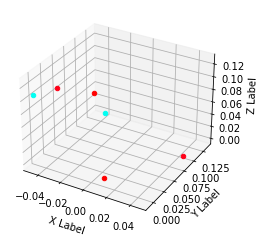

In [301]:
from matplotlib import pyplot as plt
from matplotlib import patches

def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)



fig = plt.figure()
ax = fig.add_subplot(projection='3d')

length = 3
start_point = random.randint(0, 1000)
cmap = get_cmap(len(train_dataset.position[start_point:start_point+length]))

for i, (pos,actuation) in enumerate(
    zip(train_dataset.position[start_point:start_point+length],
        train_dataset.motor_control[start_point:start_point+length])):
    
    
    pos_ = pos[0,:,0]
    ax.scatter(pos_[0], pos_[1], pos_[2], c=cmap(i))
    
    actuation = actuation/10_000
    ax.scatter(actuation[0], actuation[1], 0, c=cmap(i))
    
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')

plt.show()
    

In [302]:
# pos_[:,0,0].shape

In [303]:
# from matplotlib import pyplot as plt

# fig = plt.figure()
# ax = fig.add_subplot(projection='3d')


# for pos in train_dataset.position:
#     pos_ = pos[0,:,0]
#     ax.scatter(pos_[0], pos_[1], pos_[2], c='r')
    
#     ax.set_xlabel('X Label')
#     ax.set_ylabel('Y Label')
#     ax.set_zlabel('Z Label')

# for pos in ext_dataset.position:
#     pos_ = pos[0,:,0]
#     ax.scatter(pos_[0], pos_[1], pos_[2], c='b')
    
#     ax.set_xlabel('X Label')
#     ax.set_ylabel('Y Label')
#     ax.set_zlabel('Z Label')


# for actuation in train_dataset.motor_control:
#     actuation = actuation/10_000
#     ax.scatter(actuation[0], actuation[1], 0, c='k')

# plt.show()
    

In [304]:
torch.max(train_dataset.motor_control)

tensor(1433.0317)

In [305]:
rest_pos = model(torch.zeros(1,2).to(torch.float))[0,-1].detach().numpy()

In [306]:
idx = 4

train_dataset.motor_control[idx], train_dataset.position[idx]

(tensor([-604.5219,  754.0942]),
 tensor([[[-0.0292],
          [-0.0141],
          [ 0.1159]]]))

tensor([[341.9873,  30.7242]])
tensor([-0.0003,  0.0099,  0.1244])


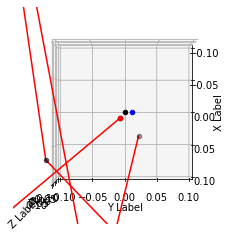

tensor([[-734.9996,  328.2905]])
tensor([-0.0177, -0.0222,  0.1178])


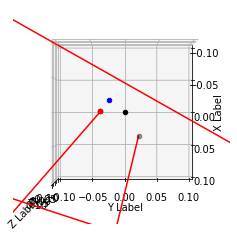

tensor([[-652.3622,  -43.2989]])
tensor([-0.0045, -0.0258,  0.1204])


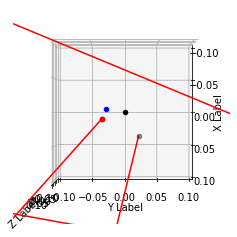

tensor([[-1378.7019,  -247.9432]])
tensor([-0.0044, -0.0433,  0.1067])


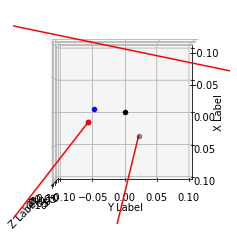

tensor([[-521.4277, -560.4946]])
tensor([ 0.0114, -0.0182,  0.1178])


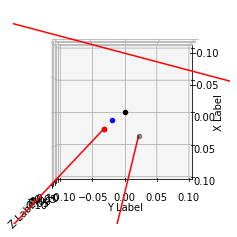

tensor([[-391.9182, -988.1289]])
tensor([ 0.0267, -0.0133,  0.1122])


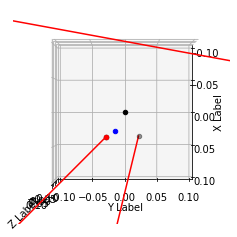

tensor([[-479.3078,  -54.9767]])
tensor([-0.0022, -0.0223,  0.1224])


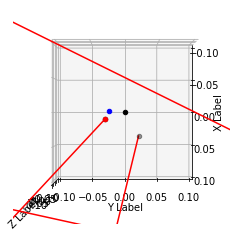

tensor([[ 94.5056, -36.5202]])
tensor([0.0036, 0.0026, 0.1258])


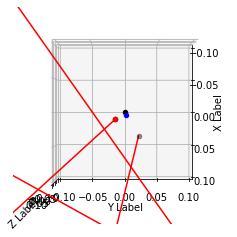

tensor([[ 44.1533, 129.2360]])
tensor([-0.0016,  0.0060,  0.1256])


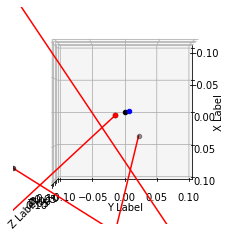

tensor([[-128.5803, -503.0440]])
tensor([ 0.0163, -0.0039,  0.1211])


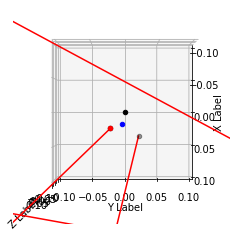

In [307]:
from matplotlib import pyplot as plt


for idx in range(10,20):

    motor_control = train_dataset.motor_control[idx][None,:]
    print(motor_control)
    target_position = train_dataset.position[idx].flatten()
    print(target_position)

    ps = model(motor_control)[0].detach().cpu().squeeze(-1).numpy()
    # ps[-1,:], target_position

    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')

    ax.scatter(0,0,0,color='k')
    i = 0
    for p in ps:
        i = i +1
        ax.scatter(p[0], p[1],p[2], color = 'k', alpha = i *0.1 + 0.3)
    
    ax.scatter(p[0], p[1],p[2], color = 'r', alpha = 1)

    for p_fr, p_to in zip(ps[:-1], ps[1:]):
        ax.plot([p_fr[0], p_to[0]], [p_fr[1], p_to[1]], [p_fr[2], p_to[2]], color="red")

    ax.scatter(target_position[0], target_position[1], target_position[2], color='b')

    ax.set_xlim(-0.10, 0.10)
    ax.set_ylim(-0.10, 0.10)
    ax.set_zlim(-0.10, 0.10)
    
    # name x,y,z label to ax
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    
    
    ax.view_init(elev=90, azim=0)

    plt.show()




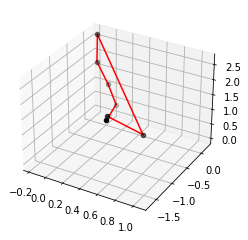

array([0.01171219, 0.01060188, 0.12558103], dtype=float32)

In [308]:
motor_control = torch.FloatTensor([1000,0]).unsqueeze(0)
ps = model(motor_control)[0].detach().cpu().squeeze(-1).numpy()

from matplotlib import pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(0,0,0,color='k')

i = 0
for p in ps:
    i = i +1
    ax.scatter(p[0], p[1],p[2], color = 'k', alpha = i *0.1)

for p_fr, p_to in zip(ps[:-1], ps[1:]):
    ax.plot([p_fr[0], p_to[0]], [p_fr[1], p_to[1]], [p_fr[2], p_to[2]], color="red")

# ax.set_xlim(-0.2, 0.2)
# ax.set_ylim(-0.2, 0.2)
# ax.set_zlim(-0.2, 0.2)
plt.show()

# print(ps[-1,:,0])
ps[-1]

<Figure size 720x720 with 0 Axes>

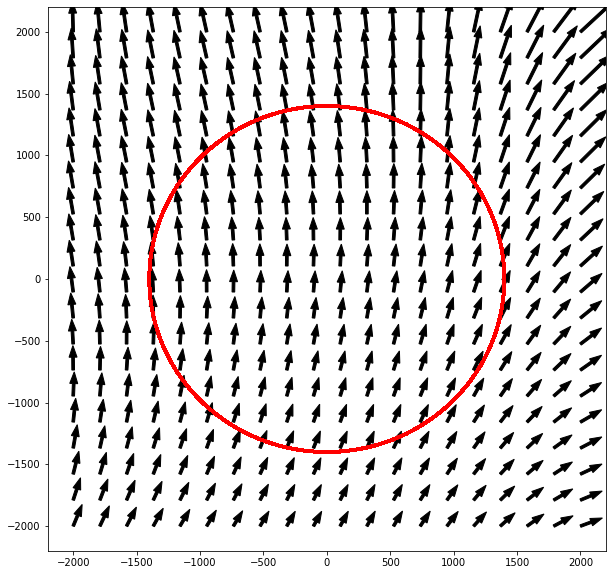

<Figure size 720x720 with 0 Axes>

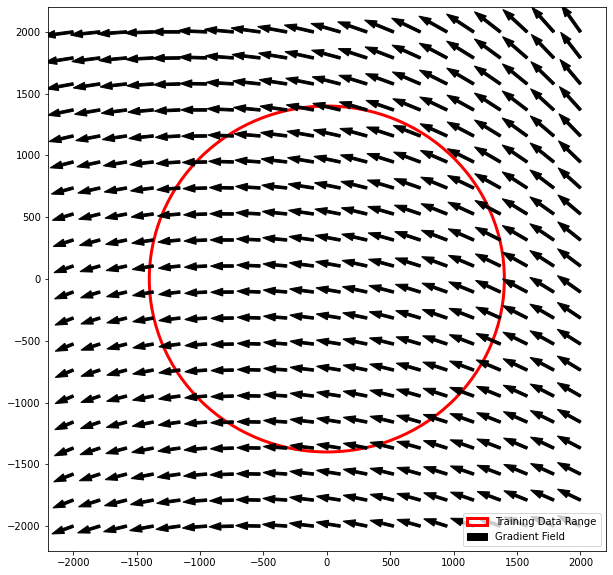

In [314]:
from jacobian import jacobian
from functools import partial

def forward_soro(soro,actuation):
    ps = soro(actuation)
    pos_EE = ps[:,-1,0:2,0]

    return pos_EE

# plot jacobian field


x = torch.linspace(-2000, 2000, 20)
y = torch.linspace(-2000, 2000, 20)
grid_x, grid_y = torch.meshgrid(x, y, indexing='ij')

fig = plt.figure(figsize=(10,10))
fig, ax = plt.subplots(figsize=(10,10))
for (x,y) in zip(grid_x.flatten(), grid_y.flatten()):
    actuation = torch.FloatTensor([x,y]).reshape(1,-1)
    jac, pos_EE = jacobian(partial(forward_soro,model), actuation)
    jac_act1 = jac[0,:,0,0] * 8e5 * 4

    # plot range of training data 
    circle=plt.Circle((0,0),1400, linewidth=3, edgecolor='r', facecolor='none')
    ax.add_patch(circle)

    # plot field
    ax.arrow(x,y, jac_act1[0], jac_act1[1], color='k', alpha=1, width=21)
    plt.xlim(-2200, 2200)
    plt.ylim(-2200, 2200)

plt.show()    

fig = plt.figure(figsize=(10,10))
fig, ax = plt.subplots(figsize=(10,10))

# plot range of training data 
circle=plt.Circle((0,0),1400, linewidth=3, edgecolor='r', facecolor='none', label="Training Data Range")
ax.add_patch(circle)
plt.arrow(x,y, 0,0, color='k', alpha=1, width=0, label='Gradient Field')

for (x,y) in zip(grid_x.flatten(), grid_y.flatten()):
    actuation = torch.FloatTensor([x,y]).reshape(1,-1)
    jac, pos_EE = jacobian(partial(forward_soro,model), actuation)
    jac_act2 = jac[0,:,0,1] * 8e5 * 4


    # plot field
    plt.arrow(x,y, jac_act2[0], jac_act2[1], color='k', alpha=1, width=21)
    plt.xlim(-2200, 2200)
    plt.ylim(-2200, 2200)

ax.legend()
plt.show()

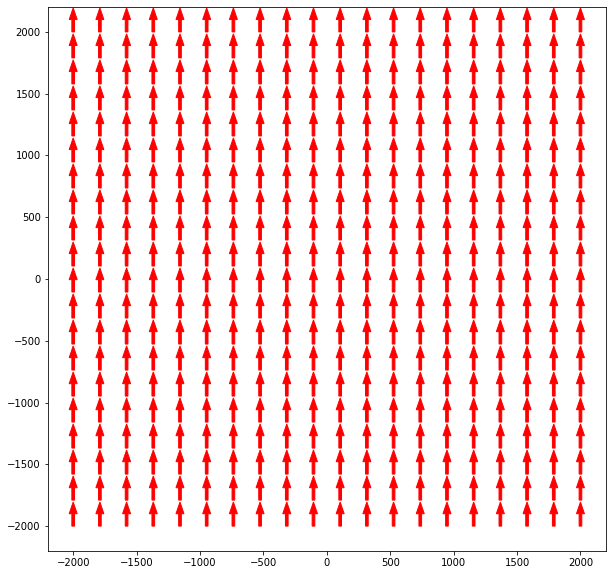

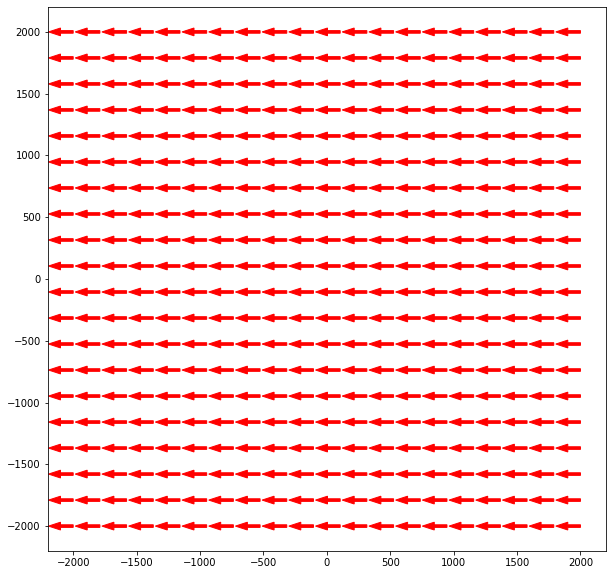

In [310]:
# Grund Truth Jacobian field

x = torch.linspace(-2000, 2000, 20)
y = torch.linspace(-2000, 2000, 20)
grid_x, grid_y = torch.meshgrid(x, y, indexing='ij')

fig = plt.figure(figsize=(10,10))
for (x,y) in zip(grid_x.flatten(), grid_y.flatten()):
    plt.arrow(x,y, 0, 100, color='r', alpha=1, width=21)
    
    # plot range of training data 
    circle=plt.Circle((0,0),1400, linewidth=3, edgecolor='k', facecolor='none')
    ax.add_patch(circle)
    plt.xlim(-2200, 2200)
    plt.ylim(-2200, 2200)

plt.show()    

fig = plt.figure(figsize=(10,10))
for (x,y) in zip(grid_x.flatten(), grid_y.flatten()):
    actuation = torch.FloatTensor([x,y]).reshape(1,-1)
    jac, pos_EE = jacobian(partial(forward_soro,model), actuation)
    jac_act2 = jac[0,:,0,1] * 8e5 * 4

    plt.arrow(x,y, -100, 0, color='r', alpha=1, width=21)
    
    # plot range of training data 
    circle=plt.Circle((0,0),1400, linewidth=3, edgecolor='k', facecolor='none')
    ax.add_patch(circle)
    plt.xlim(-2200, 2200)
    plt.ylim(-2200, 2200)

plt.show()